In [1]:
%pip install pandas numpy torch tqdm seaborn matplotlib

You should consider upgrading via the '/Users/Rafa/Documents/Code/BC/COMPUTER SCIENCE/DL/LOBnet/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('..')

import torch
import os
import torch.nn as nn
import pandas as pd 
import numpy as np
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from LOBnet.Models import DeepLOB_Network_v1
from LOBnet.Orderbooks import FI2010_Orderbook_Optimized

In [3]:
datapath = "../data/BenchmarkDatasets_csv"
window_size = 100
overlap_percent = 25  # 25% overlap between windows
num_workers = 6


In [4]:
# initialize dataset
dataset = FI2010_Orderbook_Optimized(
    root_path=datapath,
    venue="NoAuction",
    normalization_type="Zscore",
    split="Training",
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers, 
    verbose=True
)

Processing CSV Files:   0%|          | 0/9 [00:00<?, ?it/s]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_1.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_2.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_3.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_6.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.csv
Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_4.csv


Processing CSV Files:  11%|█         | 1/9 [00:04<00:38,  4.77s/it]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_5.csv


Processing CSV Files:  22%|██▏       | 2/9 [00:10<00:39,  5.62s/it]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_8.csv


Processing CSV Files:  33%|███▎      | 3/9 [00:15<00:29,  4.94s/it]

Processing file: ../data/BenchmarkDatasets_csv/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_9.csv


Processing CSV Files: 100%|██████████| 9/9 [04:40<00:00, 31.14s/it]



Raw price movement statistics:
Mean: 1.9929
Std: 0.8862
Min: 1.0000
Max: 3.0000

Label distribution:
0    8931
1    4838
2    8771
Name: count, dtype: int64


In [6]:
# create train/test splits (80/20)
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )   
)

print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Total dataset size: 22540
Training set size: 18032
Test set size: 4508


In [7]:
# look at first batch
for batch in train_loader:
    batch_X, batch_y = batch  # unpack batch tuple
    print(f"Batch X shape: {batch_X.shape}")  # should be (batch_size, 100, 40)
    print(f"Batch y shape: {batch_y.shape}")
    break

Batch X shape: torch.Size([32, 1, 100, 40])
Batch y shape: torch.Size([32, 3])


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLOB_Network_v1(y_len=3, device=device).to(device) 
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
num_epochs = 25
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_X, batch_y in pbar:
        batch_X = batch_X.float().to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(batch_y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        running_loss += loss.item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.4f}',
            'acc': f'{100 * correct/total:.2f}%'
        })
    
    # Epoch statistics
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}')
    
    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_model.pth')

print('Training finished!')

Epoch 1/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 1 Loss: 1.0296


Epoch 2/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 2 Loss: 0.9467


Epoch 3/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 3 Loss: 0.9114


Epoch 4/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 4 Loss: 0.8818


Epoch 5/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 5 Loss: 0.8558


Epoch 6/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 6 Loss: 0.8301


Epoch 7/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 7 Loss: 0.8103


Epoch 8/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 8 Loss: 0.7860


Epoch 9/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 9 Loss: 0.7679


Epoch 10/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 10 Loss: 0.7433


Epoch 11/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 11 Loss: 0.7257


Epoch 12/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 12 Loss: 0.6981


Epoch 13/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 13 Loss: 0.6780


Epoch 14/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 14 Loss: 0.6577


Epoch 15/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 15 Loss: 0.6400


Epoch 16/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 16 Loss: 0.6165


Epoch 17/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 17 Loss: 0.5975


Epoch 18/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 18 Loss: 0.5811


Epoch 19/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 19 Loss: 0.5648


Epoch 20/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 20 Loss: 0.5381


Epoch 21/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 21 Loss: 0.5216


Epoch 22/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 22 Loss: 0.5020


Epoch 23/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 23 Loss: 0.4792


Epoch 24/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 24 Loss: 0.4653


Epoch 25/25:   0%|          | 0/564 [00:00<?, ?it/s]

Epoch 25 Loss: 0.4465
Training finished!


In [9]:
def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # convert one-hot encoded outputs to class predictions
            predictions = outputs.argmax(dim=1)
            true_labels = batch_y.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
    
    return all_predictions, all_labels

Loading saved model from best_model.pth


/var/folders/6y/rz_n_6x924d63ryw6s3z5jch0000gn/T/ipykernel_44019/2508686073.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)



Classification Report:
              precision    recall  f1-score   support

 No Movement       0.64      0.65      0.64      1833
          Up       0.75      0.66      0.71       952
        Down       0.62      0.64      0.63      1723

    accuracy                           0.65      4508
   macro avg       0.67      0.65      0.66      4508
weighted avg       0.65      0.65      0.65      4508



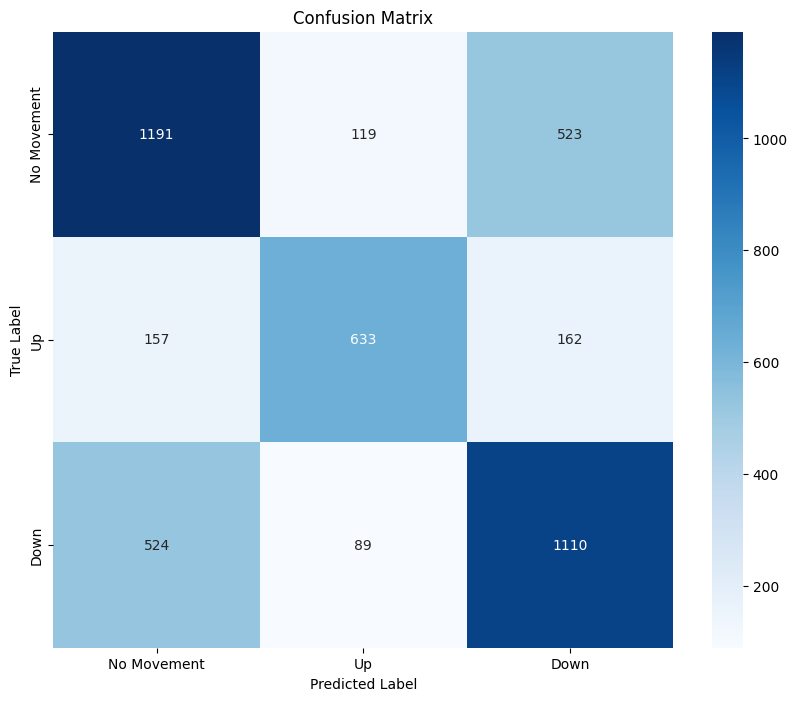

In [10]:
# load the saved model state if it exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = 'best_model.pth'
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # set to evaluation mode
else:
    print(f"No saved model found at {model_path}. Please train the model first.")
    exit()

predictions, true_labels = evaluate_model(model, test_loader, device)

print("\nClassification Report:")
print(classification_report(true_labels, predictions, 
                          target_names=['No Movement', 'Up', 'Down']))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Movement', 'Up', 'Down'],
            yticklabels=['No Movement', 'Up', 'Down'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()